Notebook for various spectra visualization methods
Will work against persisted data here, but methods should work in other contexts

In [4]:
#imports and env
import numpy as np
import pickle
from matplotlib import pyplot as plt
from pathlib import Path
#update path to use our packages
sys.path.insert(0, os.path.abspath('..'))
from libs_unet.training.spec_maker import spectrum_maker
#define absolute path to repo top level and then relative vs. that
top_dir = Path.cwd().parent #working directory for notebook should be location of notebook
rel_path = 'data' 
datapath = top_dir / rel_path

/Users/matt/CloudGit_local/github/gss/phaseMAP/envs/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
#load atomic data scaled to unit aggregate intensity
with open(datapath / 'rel_int/top30_spec.pickle', 'rb') as f:
    atom_dict = pickle.load(f)

#Build array of fist 94 element labels and abundance from text files (wikipedia)
elem_symb = np.loadtxt(datapath / "abundance/elements_94.csv", dtype=str)
elem_abund = np.loadtxt(datapath / "abundance/abundance_94.csv")

<function matplotlib.pyplot.show(close=None, block=None)>

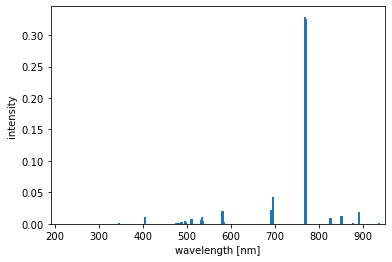

In [6]:
#update element to see atomic spectra
elem = "K"
x_spec=atom_dict[elem][:,0]
y_spec=atom_dict[elem][:,1]
plt.bar(x=x_spec, height = y_spec, width=5) #note width impacts line vis
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.xlim([190, 950]) #note data may go beyond this range
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

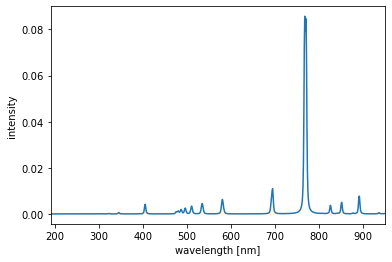

In [9]:
#Make an experimental spectrum with spread around these exact lines
elem = "K"
my_maker = spectrum_maker(20)
wave, spec = my_maker.peak_maker(elem)
plt.plot(wave, spec) 
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.xlim([190, 950]) #note data may go beyond this range
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

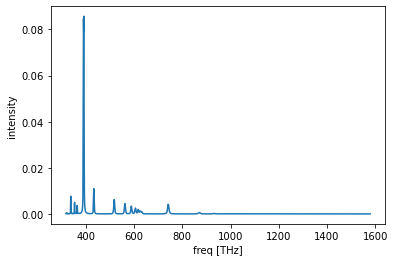

In [14]:
#look at the graph in frequency domain ~c/lambda
c_const = 3e8
freq = (c_const/wave)/1e3 #wave is 1e9m and THz is 1e12
plt.plot(freq, spec) 
plt.xlabel('freq [THz]')
plt.ylabel('intensity')
#plt.xlim([190, 950]) #note data may go beyond this range
plt.show

0.0013923785203433952


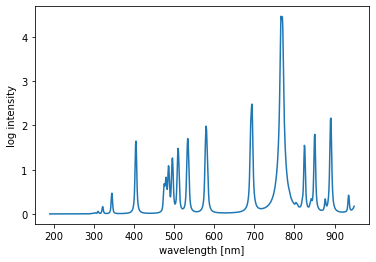

In [18]:
#Look at log transform of the intensity data. Increase level first
l_spec = np.log(spec*1000+1)
plt.plot(wave, l_spec) 
plt.xlabel('wavelength [nm]')
plt.ylabel('log intensity')
#plt.xlim([190, 950]) #note data may go beyond this range
plt.show
print(np.min(l_spec))